<a href="https://colab.research.google.com/github/hayaPEPE/face_reco/blob/main/m1research20240521_h_1010.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 学習に用いるデータセットの準備

データセットは、次の３つのカテゴリに分割する必要がある。

* **train**: 訓練に用いるデータセット。学習器はこのデータに対して正しい答えを出力するように学習を行う
* **validation**: 検証に用いるデータセット。訓練データで学習を行った学習器の汎化性を確認するために用いる
* **test**: テストに用いるデータセット。学習に全く関与していないデータでの精度検証が必要となるため、あらかじめテスト用データは分けておく必要がある

それぞれどの画像がどのデータセットにカテゴライズされているか、`datasets/dataset_cls/split_list` にあるテキストファイル (`train.txt`, `validation.txt`, `test.txt`) に記述してある。

In [2]:
import os
import random
import numpy as np
import skimage.io as io
from torch.utils.data import Dataset

class PreprocessedDataset(Dataset):
    def __init__(
            self,
            root_path,
            split_list,
            train=False
    ):
        self.root_path = root_path
        with open(split_list) as f:
            self.split_list = [line.rstrip() for line in f]
        self.dtype = np.float32
        self.train = train

    def __len__(self):
        return len(self.split_list)

    # 画像を返す
    def _get_image(self, i):
        image = io.imread(os.path.join(self.root_path, self.split_list[i]))
        image = self._min_max_normalize_one_image(image)
        if self.train:
            image = self._augmentation_image(image)
        return np.expand_dims(image.astype(self.dtype), axis=0)

    # 画像を[0, 1]に正規化
    def _min_max_normalize_one_image(self, image):
        max_int = image.max()
        min_int = image.min()
        out = (image.astype(np.float32) - min_int) / (max_int - min_int)
        return out

    # 画像を回転 and/or 反転
    def _augmentation_image(self, image):
        image = np.rot90(image, random.randint(0, 3))
        if random.randint(0, 1):
            image = np.fliplr(image)
        return image

    # ラベル (生:1, 死: 0) を返す
    def _get_label(self, i):
        label = 0 if 'dead' in self.split_list[i] else 1
        return label

    # 画像とそれに紐づいたラベル (生:1, 死: 0) を返す
    def __getitem__(self, i):
        x, y = self._get_image(i), self._get_label(i)
        return x, y

このクラスでは、引数に渡した `split_list` (`train.txt`, `validation.txt`, `test.txt`のどれか) に従って、画像とラベルのペアを出力するための `__getitem__()` 関数が用意してある。実際に、`__getitem__()` を次のように動かしてみる。

Text(0.5, 1.0, 'label: 0')

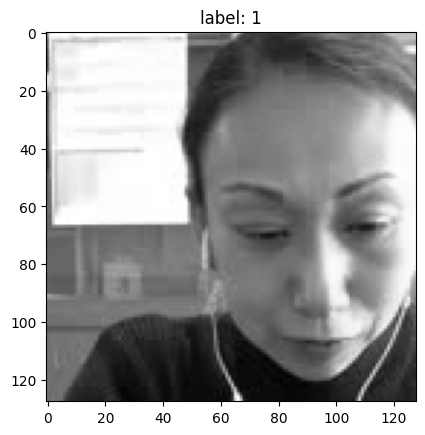

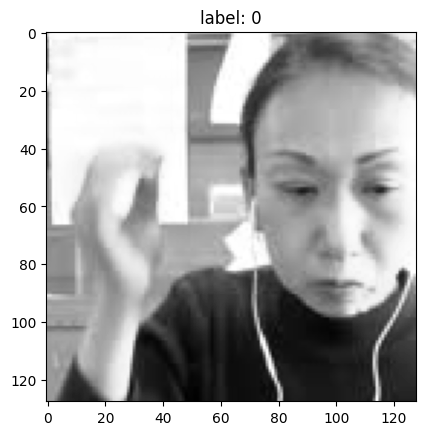

In [3]:
import matplotlib.pylab as plt

#root_path = './dataset_cls'
root_path = '/content/drive/MyDrive/Colab_Notebooks/tokkuma_datasets/dataset_cls'
split_list = '/content/drive/MyDrive/Colab_Notebooks/tokkuma_datasets/dataset_cls/split_list/train.txt'

dataset = PreprocessedDataset(root_path, split_list)

%matplotlib inline
# train.txtの20番目の画像とラベルを取得
img, label = dataset.__getitem__(20)
plt.figure()
plt.imshow(img[0], cmap='gray')
plt.title('label: {}'.format(label))

# train.txtの110番目の画像とラベルを取得
img, label = dataset.__getitem__(110)
plt.figure()
plt.imshow(img[0], cmap='gray')
plt.title('label: {}'.format(label))

この結果から、画像とラベルが正しい組み合わせで取得できていることが確認できる。

## CNNモデルの定義

画像分類を行うCNNは、畳み込み層と全結合層に分かれている。畳み込み層は `nn.Conv2d(in_ch, out_ch, ksize, stride, pad)` ,
全結合層は  `nn.Linear(in_ch, out_ch)` のように記述する。ここで指定する値は、モデルの構造を決定するパラメータ、すなわちハイパーパラメータとよばれる。

```
    in_ch:   入力チャネル数
    out_ch:  出力チャネル数
    ksize:   畳み込みカーネルサイズ
    stride:  カーネルの移動サイズ
    pad:     パディングサイズ
```

In [4]:
import torch
from torch import nn

class ClassificationModel(nn.Module):
    def __init__(self, n_class=2):
        super(ClassificationModel, self).__init__()
        # ネットワークの部品 (層) を用意
        self.conv1 = nn.Conv2d(1, 32, 5, 1, 2)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 5, 1, 2)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, 3, 1, 1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, 3, 1, 1)
        self.bn4 = nn.BatchNorm2d(256)
        self.fc5 = nn.Linear(16384, 1024)
        self.fc6 = nn.Linear(1024, n_class)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        # 各層を接続
        x = x.clone().detach()
        h = self.relu(self.conv1(x))
        h = self.pool(self.bn1(h))
        h = self.relu(self.conv2(h))
        h = self.pool(self.bn2(h))
        h = self.relu(self.conv3(h))
        h = self.pool(self.bn3(h))
        h = self.relu(self.conv4(h))
        h = self.pool(self.bn4(h))
        h = self.dropout(self.relu(self.fc5(h.view(h.shape[0],-1))))
        return self.fc6(h)

#print(model) # 追加！

## 出力関数

ここまででCNNモデルに用いられる関数と伝搬の仕方を定義したが、最後の出力される層には別の関数を用いる。この出力関数を用いることで、問題に応じた値の範囲になるように調節することができる。一般的に、分類問題では出力関数に**Softmax**関数が用いられる。Softmax関数は、$d$次元のベクトル${\bf y} \in \mathbb{R}^d$が与えられたとき、その各次元の値の合計が1になるように正規化されるため、確率分布のような出力となる。
${\bf y}$の$i$番目の次元を$y_i$とすると、Softmax関数は以下のように定義される。

$$
{\rm Softmax}({\bf y})_i = \frac{\exp(y_i)}{\sum_{j=1}^d \exp(y_j)}
$$

このように表現されるSoftmax関数を出力関数として用いる場合、`F.softmax` と記述する。

参考: https://docs.chainer.org/en/stable/reference/generated/chainer.functions.softmax.html

## CNNモデルによる推論

ここまでで、学習に用いるデータセットとCNNモデルを用意することができた。まずはこれらを用いて、実際に画像分類の推論ができるのか試してみる。

In [5]:
import torch.nn.functional as F

root_path = '/content/drive/MyDrive/Colab_Notebooks/tokkuma_datasets/dataset_cls'
split_list = '/content/drive/MyDrive/Colab_Notebooks/tokkuma_datasets/dataset_cls/split_list/test.txt'

# データセットを用意
test_dataset = PreprocessedDataset(root_path, split_list, train=False)

# 未学習のモデルを作成
model = ClassificationModel(n_class=2)

print('=====================')
for i in range(5):
    with torch.no_grad():
        # テスト画像とラベルを1セット取得
        img, label = test_dataset.__getitem__(i)
        # テスト画像の生死を推論
        pred = model(torch.tensor(np.expand_dims(img, axis=0)))
        # 出力関数により生・死の確率を求める
        pred = F.softmax(pred, dim=1)

    print('test {}'.format(i + 1))
    print('  pred: {}'.format(np.argmax(pred.data)))     # 確率が高い方のラベルを表示
    print('  label: {}'.format(label))                                   # 正解のラベルを表示
    print('=====================')

test 1
  pred: 1
  label: 1
test 2
  pred: 1
  label: 1
test 3
  pred: 1
  label: 1
test 4
  pred: 1
  label: 1
test 5
  pred: 1
  label: 1


このように、画像をCNNモデルに入力して、出力された結果から画像分類の推論を確認することができる。ただ、このCNNモデルは学習が行われていない状態なので、画像分類の結果もランダムに出力した結果とさほど変わらないことがわかる。

それでは次項から学習を行うための準備を行っていく。

## CNNモデルの学習

CNNモデルに目的関数を定義して、最適化手法も決定したため、実際に学習を行ってみる。

## Accuracyを指標とした学習

In [6]:
%time
import os
import json
import torch
from torch import optim
from torch.utils.data import DataLoader
from sklearn import metrics

class Trainer(object):

    def __init__(self, root_path, train_path, val_path, batchsize, epoch, out='result_cls', device=-1, eval_metrics='accuracy'):

        # train データセットを用意
        train_dataset = PreprocessedDataset(root_path, train_path, train=True)
        # validation データセットを用意
        val_dataset = PreprocessedDataset(root_path, val_path, train=False)

        # 未学習のモデルを作成
        self.model = ClassificationModel(n_class=2).to(torch.device(device))

        # 最適化手法を選択 (Adam)
        self.optimizer = optim.Adam(params=self.model.parameters())

        # train データセットを学習器に渡す形式に変換
        self.train_iter = DataLoader(dataset=train_dataset, batch_size=batchsize, shuffle=True)
        # validation データセットを学習器に渡す形式に変換
        self.val_iter = DataLoader(dataset=val_dataset, batch_size=batchsize, shuffle=False)

        self.epoch = epoch
        self.out = out
        os.makedirs(out, exist_ok=True)
        self.device = device
        self._best_accuracy = 0.0
        self.eval_metrics = eval_metrics
        self.lossfun = nn.CrossEntropyLoss()
        self.results = {}

    def train(self):
        for epoch in range(1, self.epoch + 1):
            print('[epoch {}]'.format(epoch))
            loss_train, eval_results_train = self._train_step(self.model, self.train_iter)
            loss_val, eval_results_val = self._val_step(self.model, self.val_iter)
            self._save_log(epoch, loss_train, loss_val, eval_results_train, eval_results_val)

            if self.best_eval_result(eval_results_val):
                torch.save(self.model.to('cpu'), os.path.join(self.out, 'best_model.npz'))
                self.model.to(torch.device(self.device))
                best_epoch = epoch
                print("Saved better model selected by validation.")
        print('best {}: {}'.format(self.eval_metrics, self._best_accuracy))
        print('best epoch: {}'.format(best_epoch))
        # モデルの重みを保存
        torch.save(self.model.state_dict(), os.path.join(self.out, '/content/drive/MyDrive/Colab_Notebooks/tokkuma_datasets/dataset_cls/h_1.pth')) # 追加！

    def _train_step(self, model, data_iterator):
        model.train()
        output_list, truth_list, loss_list = [], [], []
        for batch in data_iterator:
            input, label = batch
            self.optimizer.zero_grad()
            pred = model(input.to(torch.device(self.device)))
            output_list.append(pred.to(torch.device('cpu')).clone().detach())
            truth_list.append(label.clone().detach())
            label = label.type(torch.LongTensor)
            loss = self.lossfun(pred.squeeze(1), label.to(torch.device(self.device)).view(len(label)))
            loss_list.append(loss.to(torch.device('cpu')).clone().detach())
            loss.backward()
            self.optimizer.step()
        eval_results = self.evaluate(output_list, truth_list)
        loss_train = float(abs(np.mean(loss_list)))
        print('train loss: {}'.format(loss_train))
        return loss_train, eval_results

    def _val_step(self, model, data_iterator):
        model.eval()
        output_list, truth_list, loss_list = [], [], []
        for batch in data_iterator:
            input, label = batch
            with torch.no_grad():
                pred = model(input.to(torch.device(self.device)))
            output_list.append(pred.to(torch.device('cpu')).clone().detach())
            truth_list.append(label.clone().detach())
            label = label.type(torch.LongTensor)
            loss = self.lossfun(pred.squeeze(1), label.to(torch.device(self.device)).view(len(label)))
            loss_list.append(loss.to(torch.device('cpu')).clone().detach().numpy())
        eval_results = self.evaluate(output_list, truth_list)
        print("[{}] {}, loss: {}".format("validation", self.print_eval_results(eval_results), abs(np.mean(loss_list))))
        return abs(np.mean(loss_list)), eval_results

    def evaluate(self, predict, truth):
        y_trues, y_preds = [], []
        for y_true, logit in zip(truth, predict):
            y_true = y_true.cpu().numpy()
            y_pred = np.argmax(F.softmax(logit, dim=1), axis=1)
            y_trues.append(y_true)
            y_preds.append(y_pred)
        y_true = np.concatenate(y_trues, axis=0)
        y_pred = np.concatenate(y_preds, axis=0).reshape(len(y_true), 1)
        accuracy = metrics.accuracy_score(y_true, y_pred)
        precision = metrics.precision_score(y_true, y_pred, pos_label=1)
        recall = metrics.recall_score(y_true, y_pred, pos_label=1)
        f1 = metrics.f1_score(y_true, y_pred, pos_label=1)
        return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

    def print_eval_results(self, results):
        return ", ".join(
            [str(key) + "=" + "{:.4f}".format(value)
             for key, value in results.items()])

    def best_eval_result(self, eval_results):
        assert self.eval_metrics in eval_results, \
            "Evaluation doesn't contain metrics '{}'." \
            .format(self.eval_metrics)

        accuracy = eval_results[self.eval_metrics]
        if accuracy >= self._best_accuracy:
            self._best_accuracy = accuracy
            return True
        else:
            return False

    def _save_log(self, epoch, loss_train, loss_val, eval_results_train, eval_results_val):
        result_each_epoch = {}
        result_each_epoch['epoch'] = epoch
        result_each_epoch['main/loss'] = float(loss_train)
        result_each_epoch['main/accuracy'] = float(eval_results_train["accuracy"])
        result_each_epoch['main/precision'] = float(eval_results_train["precision"])
        result_each_epoch['main/recall'] = float(eval_results_train["recall"])
        result_each_epoch['main/f1'] = float(eval_results_train["f1"])
        result_each_epoch['val/main/loss'] = float(loss_val)
        result_each_epoch['val/main/accuracy'] = float(eval_results_val["accuracy"])
        result_each_epoch['val/main/precision'] = float(eval_results_val["precision"])
        result_each_epoch['val/main/recall'] = float(eval_results_val["recall"])
        result_each_epoch['val/main/f1'] = float(eval_results_val["f1"])
        self.results[epoch] = result_each_epoch
        with open(os.path.join(self.out, 'log'), 'w') as f:
            json.dump(self.results, f, indent=4)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.77 µs


In [7]:
%%time
os.makedirs('results', exist_ok=True)
root_path = '/content/drive/MyDrive/Colab_Notebooks/tokkuma_datasets/dataset_cls'
train_path = '/content/drive/MyDrive/Colab_Notebooks/tokkuma_datasets/dataset_cls/split_list/train.txt'
val_path = '/content/drive/MyDrive/Colab_Notebooks/tokkuma_datasets/dataset_cls/split_list/validation.txt'
batchsize = 10
epoch = 10
device = "cuda:0"   # or "cpu"
eval_metrics = "accuracy"

trainer = Trainer(root_path, train_path, val_path, batchsize, epoch, out='results/result_cls_1', device=device, eval_metrics=eval_metrics)

# 訓練開始
trainer.train()

[epoch 1]
train loss: 1.1294217109680176
[validation] accuracy=0.5000, precision=0.5000, recall=1.0000, f1=0.6667, loss: 31.903226852416992
Saved better model selected by validation.
[epoch 2]
train loss: 1.2672021389007568
[validation] accuracy=0.5000, precision=0.5000, recall=1.0000, f1=0.6667, loss: 94.75715637207031
Saved better model selected by validation.
[epoch 3]
train loss: 0.9851170182228088
[validation] accuracy=0.5250, precision=0.5128, recall=1.0000, f1=0.6780, loss: 12.380657196044922
Saved better model selected by validation.
[epoch 4]
train loss: 0.18280988931655884
[validation] accuracy=0.6250, precision=0.5714, recall=1.0000, f1=0.7273, loss: 5.91045618057251
Saved better model selected by validation.
[epoch 5]
train loss: 0.21913699805736542
[validation] accuracy=1.0000, precision=1.0000, recall=1.0000, f1=1.0000, loss: 0.0
Saved better model selected by validation.
[epoch 6]
train loss: 0.7904371619224548
[validation] accuracy=0.5000, precision=0.5000, recall=1.000

## テストデータを用いた画像分類の精度

学習器は訓練データに対して最小の誤差となるように学習を進める。一方で、今回学習器に解かせたい分類問題は、分類精度 (Accuracy) が高いモデルこそが最良のモデルであることは明らかである。そのため、訓練データで誤差が最小になるように学習を進め、検証データで分類精度が最高となるモデルを得るのが理想的である。以下のセルでは、誤差が最小となった際に保存したモデルと分類精度が最高になった際に保存したモデルの精度を、テストデータを用いて検証する。

In [13]:
%%time
import numpy as np
import torch

def test(root_path, test_path, model_path, out='results/result_cls_test', device=-1):

    # データセットを用意
    test_dataset = PreprocessedDataset(root_path, test_path, train=False)

    # 学習済みモデルの読み込み
    model = torch.load(model_path)

    true_conut = 0
    for i in range(test_dataset.__len__()):
        with torch.no_grad():
            # テスト画像とラベルを1セット取得
            x, t = test_dataset.__getitem__(i)
            # テスト画像の生死を推論
            # y = model(np.expand_dims(x, axis=0))
            y = model(torch.tensor(np.expand_dims(x, axis=0)))
        # 推論した分類結果が正解ラベルと一致していたら true_count　に1を加算
        if np.argmax(y.data) == t:
            true_conut += 1
    # accuracy を算出
    accuracy = true_conut / test_dataset.__len__()
    os.makedirs(out, exist_ok=True)
    with open(os.path.join(out, 'result.txt'), 'w') as f:
        f.write('accuracy: {}\n'.format(accuracy))
    print('accuracy: {}'.format(accuracy))


root_path = '/content/drive/MyDrive/Colab_Notebooks/tokkuma_datasets/dataset_cls'
test_path = '/content/drive/MyDrive/Colab_Notebooks/tokkuma_datasets/dataset_cls/split_list/test.txt'

# 検証精度が最高の学習済みモデルでテスト
print('Test for best accuracy model')
model_path = 'results/result_cls_1/best_model.npz'
# test(root_path, test_path, model_path, 'results/result_cls_1_test', device=-1) # CPU
test(root_path, test_path, model_path, 'results/result_cls_1_test', device=0) # GPU

Test for best accuracy model
accuracy: 1.0
CPU times: user 4.16 s, sys: 63.1 ms, total: 4.22 s
Wall time: 1.15 s


In [14]:
%%time
# 5分割交差検証の設定
root_path = '/content/drive/MyDrive/Colab_Notebooks/tokkuma_datasets/dataset_cls'
batchsize = 10
epoch = 300
eval_metrics = "accuracy"
device = "cuda:0"   # or "cpu"

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 6.68 µs


In [15]:
train_path_fold1 = '/content/drive/MyDrive/Colab_Notebooks/tokkuma_datasets/dataset_cls/split_list/fold1/train.txt'
val_path_fold1 = '/content/drive/MyDrive/Colab_Notebooks/tokkuma_datasets/dataset_cls/split_list/fold1/validation.txt'

trainer_fold1 = Trainer(root_path, train_path_fold1, val_path_fold1, batchsize, epoch=epoch, out='results/result_cls_fold1', device=device, eval_metrics=eval_metrics) # GPU
trainer_fold1.train()

[epoch 1]
train loss: 2.427084445953369
[validation] accuracy=0.5000, precision=0.5000, recall=1.0000, f1=0.6667, loss: 29.140073776245117
Saved better model selected by validation.
[epoch 2]
train loss: 0.9790391325950623
[validation] accuracy=0.5000, precision=0.5000, recall=1.0000, f1=0.6667, loss: 39.19359588623047
Saved better model selected by validation.
[epoch 3]
train loss: 0.9460015892982483
[validation] accuracy=0.5000, precision=0.5000, recall=1.0000, f1=0.6667, loss: 48.30199432373047
Saved better model selected by validation.
[epoch 4]
train loss: 0.4552912712097168
[validation] accuracy=0.6500, precision=0.5882, recall=1.0000, f1=0.7407, loss: 4.856574535369873
Saved better model selected by validation.
[epoch 5]
train loss: 0.062306180596351624
[validation] accuracy=0.7000, precision=0.6250, recall=1.0000, f1=0.7692, loss: 5.69932222366333
Saved better model selected by validation.
[epoch 6]
train loss: 0.6429442763328552
[validation] accuracy=1.0000, precision=1.0000, 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


train loss: 0.61171954870224
[validation] accuracy=1.0000, precision=1.0000, recall=1.0000, f1=1.0000, loss: 0.0
Saved better model selected by validation.
[epoch 39]
train loss: 0.15262261033058167
[validation] accuracy=1.0000, precision=1.0000, recall=1.0000, f1=1.0000, loss: 0.0
Saved better model selected by validation.
[epoch 40]
train loss: 0.4049181640148163
[validation] accuracy=1.0000, precision=1.0000, recall=1.0000, f1=1.0000, loss: 0.0
Saved better model selected by validation.
[epoch 41]
train loss: 0.4093961715698242
[validation] accuracy=0.5000, precision=0.5000, recall=1.0000, f1=0.6667, loss: 65.17029571533203
[epoch 42]
train loss: 0.1855655163526535
[validation] accuracy=0.6250, precision=0.5714, recall=1.0000, f1=0.7273, loss: 32.87538146972656
[epoch 43]
train loss: 0.0001688669144641608
[validation] accuracy=0.7500, precision=0.6667, recall=1.0000, f1=0.8000, loss: 13.061957359313965
[epoch 44]
train loss: 0.0
[validation] accuracy=0.9000, precision=0.8333, recall

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


train loss: 4.65977144241333
[validation] accuracy=0.5250, precision=0.5128, recall=1.0000, f1=0.6780, loss: 386.2900695800781
[epoch 94]
train loss: 6.009303092956543
[validation] accuracy=1.0000, precision=1.0000, recall=1.0000, f1=1.0000, loss: 0.0
Saved better model selected by validation.
[epoch 95]
train loss: 2.520082473754883
[validation] accuracy=1.0000, precision=1.0000, recall=1.0000, f1=1.0000, loss: 0.0
Saved better model selected by validation.
[epoch 96]
train loss: 0.0
[validation] accuracy=0.8750, precision=0.8000, recall=1.0000, f1=0.8889, loss: 22.451139450073242
[epoch 97]
train loss: 1.6678155660629272
[validation] accuracy=0.9500, precision=0.9091, recall=1.0000, f1=0.9524, loss: 4.92708683013916
[epoch 98]
train loss: 0.0
[validation] accuracy=0.9250, precision=0.8696, recall=1.0000, f1=0.9302, loss: 13.128527641296387
[epoch 99]
train loss: 0.11322502046823502
[validation] accuracy=0.8750, precision=0.8000, recall=1.0000, f1=0.8889, loss: 30.454736709594727
[epo

In [16]:
train_path_fold2 = '/content/drive/MyDrive/Colab_Notebooks/tokkuma_datasets/dataset_cls/split_list/fold2/train.txt'
val_path_fold2 = '/content/drive/MyDrive/Colab_Notebooks/tokkuma_datasets/dataset_cls/split_list/fold2/validation.txt'

trainer_fold2 = Trainer(root_path, train_path_fold2, val_path_fold2, batchsize, epoch=epoch, out='results/result_cls_fold2', device=device, eval_metrics=eval_metrics)
trainer_fold2.train()

[epoch 1]
train loss: 3.1533427238464355
[validation] accuracy=0.5000, precision=0.5000, recall=1.0000, f1=0.6667, loss: 9.58930778503418
Saved better model selected by validation.
[epoch 2]
train loss: 0.4209226965904236
[validation] accuracy=0.5000, precision=0.5000, recall=1.0000, f1=0.6667, loss: 11.213788986206055
Saved better model selected by validation.
[epoch 3]
train loss: 1.1222957372665405
[validation] accuracy=1.0000, precision=1.0000, recall=1.0000, f1=1.0000, loss: 0.001218648860231042
Saved better model selected by validation.
[epoch 4]
train loss: 1.1665210723876953
[validation] accuracy=1.0000, precision=1.0000, recall=1.0000, f1=1.0000, loss: 1.3466988093568943e-05
Saved better model selected by validation.
[epoch 5]
train loss: 0.3921360373497009
[validation] accuracy=1.0000, precision=1.0000, recall=1.0000, f1=1.0000, loss: 0.0
Saved better model selected by validation.
[epoch 6]
train loss: 0.3158870339393616
[validation] accuracy=1.0000, precision=1.0000, recall=

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


train loss: 0.124576136469841
[validation] accuracy=0.9750, precision=1.0000, recall=0.9500, f1=0.9744, loss: 0.09751953929662704
[epoch 25]
train loss: 0.18681730329990387
[validation] accuracy=1.0000, precision=1.0000, recall=1.0000, f1=1.0000, loss: 0.0
Saved better model selected by validation.
[epoch 26]
train loss: 0.6561031937599182
[validation] accuracy=1.0000, precision=1.0000, recall=1.0000, f1=1.0000, loss: 0.0
Saved better model selected by validation.
[epoch 27]
train loss: 0.6301872730255127
[validation] accuracy=1.0000, precision=1.0000, recall=1.0000, f1=1.0000, loss: 0.0
Saved better model selected by validation.
[epoch 28]
train loss: 0.4448586404323578
[validation] accuracy=1.0000, precision=1.0000, recall=1.0000, f1=1.0000, loss: 0.0
Saved better model selected by validation.
[epoch 29]
train loss: 0.15608415007591248
[validation] accuracy=1.0000, precision=1.0000, recall=1.0000, f1=1.0000, loss: 0.0
Saved better model selected by validation.
[epoch 30]
train loss: 

In [ ]:
train_path_fold3 = '/content/drive/MyDrive/Colab_Notebooks/tokkuma_datasets/dataset_cls/split_list/fold3/train.txt'
val_path_fold3 = '/content/drive/MyDrive/Colab_Notebooks/tokkuma_datasets/dataset_cls/split_list/fold3/validation.txt'

trainer_fold3 = Trainer(root_path, train_path_fold3, val_path_fold3, batchsize, epoch=epoch, out='results/result_cls_fold3', device=device, eval_metrics=eval_metrics)
trainer_fold3.train()

[epoch 1]
train loss: 1.5681791305541992
[validation] accuracy=0.5000, precision=0.5000, recall=1.0000, f1=0.6667, loss: 64.85848999023438
Saved better model selected by validation.
[epoch 2]
train loss: 0.7807855010032654
[validation] accuracy=0.5000, precision=0.5000, recall=1.0000, f1=0.6667, loss: 97.89703369140625
Saved better model selected by validation.
[epoch 3]
train loss: 0.3003275692462921
[validation] accuracy=0.5000, precision=0.5000, recall=1.0000, f1=0.6667, loss: 23.90262222290039
Saved better model selected by validation.
[epoch 4]
train loss: 1.959658145904541
[validation] accuracy=0.5000, precision=0.5000, recall=1.0000, f1=0.6667, loss: 40.26365661621094
Saved better model selected by validation.
[epoch 5]
train loss: 0.6129803657531738
[validation] accuracy=1.0000, precision=1.0000, recall=1.0000, f1=1.0000, loss: 0.0
Saved better model selected by validation.
[epoch 6]
train loss: 0.3455425798892975
[validation] accuracy=0.8000, precision=1.0000, recall=0.6000, f

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


train loss: 1.5551133155822754
[validation] accuracy=0.8000, precision=1.0000, recall=0.6000, f1=0.7500, loss: 2.5096261501312256
[epoch 13]
train loss: 0.6274644732475281
[validation] accuracy=0.6250, precision=0.5714, recall=1.0000, f1=0.7273, loss: 56.922916412353516
[epoch 14]
train loss: 0.7152070999145508
[validation] accuracy=0.8000, precision=0.7143, recall=1.0000, f1=0.8333, loss: 10.39331340789795
[epoch 15]
train loss: 0.6850221753120422
[validation] accuracy=1.0000, precision=1.0000, recall=1.0000, f1=1.0000, loss: 0.0
Saved better model selected by validation.
[epoch 16]
train loss: 0.30348142981529236
[validation] accuracy=0.8000, precision=1.0000, recall=0.6000, f1=0.7500, loss: 2.0137197971343994
[epoch 17]
train loss: 1.0678997039794922
[validation] accuracy=1.0000, precision=1.0000, recall=1.0000, f1=1.0000, loss: 0.0
Saved better model selected by validation.
[epoch 18]
train loss: 0.0
[validation] accuracy=1.0000, precision=1.0000, recall=1.0000, f1=1.0000, loss: 0.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


train loss: 0.0
[validation] accuracy=0.5000, precision=0.0000, recall=0.0000, f1=0.0000, loss: 189.13356018066406
[epoch 24]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


train loss: 1.5248992443084717
[validation] accuracy=1.0000, precision=1.0000, recall=1.0000, f1=1.0000, loss: 0.0
Saved better model selected by validation.
[epoch 25]
train loss: 8.566019459976815e-06
[validation] accuracy=1.0000, precision=1.0000, recall=1.0000, f1=1.0000, loss: 0.0
Saved better model selected by validation.
[epoch 26]
train loss: 0.5260168313980103
[validation] accuracy=1.0000, precision=1.0000, recall=1.0000, f1=1.0000, loss: 0.0
Saved better model selected by validation.
[epoch 27]
train loss: 0.9661809206008911
[validation] accuracy=1.0000, precision=1.0000, recall=1.0000, f1=1.0000, loss: 0.0
Saved better model selected by validation.
[epoch 28]
train loss: 0.1590595543384552
[validation] accuracy=1.0000, precision=1.0000, recall=1.0000, f1=1.0000, loss: 0.0
Saved better model selected by validation.
[epoch 29]
train loss: 9.596194286132231e-05
[validation] accuracy=1.0000, precision=1.0000, recall=1.0000, f1=1.0000, loss: 0.0
Saved better model selected by val

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


train loss: 1.0840375423431396
[validation] accuracy=1.0000, precision=1.0000, recall=1.0000, f1=1.0000, loss: 0.0
Saved better model selected by validation.
[epoch 34]
train loss: 0.0
[validation] accuracy=0.6000, precision=0.5556, recall=1.0000, f1=0.7143, loss: 100.98399353027344
[epoch 35]
train loss: 0.4539724588394165
[validation] accuracy=0.5000, precision=0.0000, recall=0.0000, f1=0.0000, loss: 45.139427185058594
[epoch 36]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


train loss: 1.2922877073287964
[validation] accuracy=0.5000, precision=0.0000, recall=0.0000, f1=0.0000, loss: 384.04901123046875
[epoch 37]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


train loss: 0.9698930978775024
[validation] accuracy=0.8750, precision=0.8000, recall=1.0000, f1=0.8889, loss: 2.993356704711914
[epoch 38]
train loss: 2.858092784881592
[validation] accuracy=1.0000, precision=1.0000, recall=1.0000, f1=1.0000, loss: 0.0
Saved better model selected by validation.
[epoch 39]
train loss: 0.0005719909677281976
[validation] accuracy=1.0000, precision=1.0000, recall=1.0000, f1=1.0000, loss: 0.0
Saved better model selected by validation.
[epoch 40]
train loss: 1.0097033977508545
[validation] accuracy=1.0000, precision=1.0000, recall=1.0000, f1=1.0000, loss: 0.0
Saved better model selected by validation.
[epoch 41]
train loss: 0.22074681520462036
[validation] accuracy=1.0000, precision=1.0000, recall=1.0000, f1=1.0000, loss: 0.0
Saved better model selected by validation.
[epoch 42]
train loss: 1.0872588157653809
[validation] accuracy=1.0000, precision=1.0000, recall=1.0000, f1=1.0000, loss: 0.0
Saved better model selected by validation.
[epoch 43]
train loss: 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


train loss: 1.445971131324768
[validation] accuracy=1.0000, precision=1.0000, recall=1.0000, f1=1.0000, loss: 0.005893243942409754
Saved better model selected by validation.
[epoch 47]
train loss: 0.5925030708312988
[validation] accuracy=1.0000, precision=1.0000, recall=1.0000, f1=1.0000, loss: 0.0
Saved better model selected by validation.
[epoch 48]
train loss: 0.0
[validation] accuracy=1.0000, precision=1.0000, recall=1.0000, f1=1.0000, loss: 0.0
Saved better model selected by validation.
[epoch 49]
train loss: 0.750379204750061
[validation] accuracy=1.0000, precision=1.0000, recall=1.0000, f1=1.0000, loss: 0.0
Saved better model selected by validation.
[epoch 50]
train loss: 0.3304859399795532
[validation] accuracy=1.0000, precision=1.0000, recall=1.0000, f1=1.0000, loss: 0.0
Saved better model selected by validation.
[epoch 51]
train loss: 0.7593104243278503
[validation] accuracy=1.0000, precision=1.0000, recall=1.0000, f1=1.0000, loss: 0.0
Saved better model selected by validatio

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


train loss: 0.0
[validation] accuracy=0.5000, precision=0.0000, recall=0.0000, f1=0.0000, loss: 118.97900390625
[epoch 113]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


train loss: 0.0
[validation] accuracy=0.7750, precision=1.0000, recall=0.5500, f1=0.7097, loss: 15.229156494140625
[epoch 114]
train loss: 0.44734859466552734
[validation] accuracy=0.6750, precision=0.6061, recall=1.0000, f1=0.7547, loss: 83.78864288330078
[epoch 115]
train loss: 1.559472918510437
[validation] accuracy=1.0000, precision=1.0000, recall=1.0000, f1=1.0000, loss: 0.0
Saved better model selected by validation.
[epoch 116]
train loss: 0.0
[validation] accuracy=0.9500, precision=1.0000, recall=0.9000, f1=0.9474, loss: 2.1098978519439697
[epoch 117]
train loss: 0.7585434317588806
[validation] accuracy=0.7500, precision=1.0000, recall=0.5000, f1=0.6667, loss: 30.8216609954834
[epoch 118]
train loss: 0.12924796342849731
[validation] accuracy=1.0000, precision=1.0000, recall=1.0000, f1=1.0000, loss: 0.0
Saved better model selected by validation.
[epoch 119]
train loss: 0.0
[validation] accuracy=1.0000, precision=1.0000, recall=1.0000, f1=1.0000, loss: 0.0
Saved better model selec

In [23]:
train_path_fold4 = '/content/drive/MyDrive/Colab_Notebooks/tokkuma_datasets/dataset_cls/split_list/fold4/train.txt'
val_path_fold4 = '/content/drive/MyDrive/Colab_Notebooks/tokkuma_datasets/dataset_cls/split_list/fold4/validation.txt'

trainer_fold4 = Trainer(root_path, train_path_fold4, val_path_fold4, batchsize, epoch=epoch, out='results/result_cls_fold4', device=device, eval_metrics=eval_metrics)
trainer_fold4.train()

TypeError: can only concatenate list (not "int") to list

In [19]:
%%time
train_path_fold5 = '/content/drive/MyDrive/Colab_Notebooks/tokkuma_datasets/dataset_cls/split_list/fold5/train.txt'
val_path_fold5 = '/content/drive/MyDrive/Colab_Notebooks/tokkuma_datasets/dataset_cls/split_list/fold5/validation.txt'

trainer_fold5 = Trainer(root_path, train_path_fold5, val_path_fold5, batchsize, epoch=epoch, out='results/result_cls_fold5', device=device, eval_metrics=eval_metrics)
trainer_fold5.train()

[epoch 1]
train loss: 3.1572518348693848
[validation] accuracy=0.5000, precision=0.5000, recall=1.0000, f1=0.6667, loss: 33.33968734741211
Saved better model selected by validation.
[epoch 2]
train loss: 0.9330779910087585
[validation] accuracy=0.5000, precision=0.5000, recall=1.0000, f1=0.6667, loss: 52.057273864746094
Saved better model selected by validation.
[epoch 3]
train loss: 0.19128307700157166
[validation] accuracy=0.5000, precision=0.5000, recall=1.0000, f1=0.6667, loss: 49.081512451171875
Saved better model selected by validation.
[epoch 4]
train loss: 0.5887460112571716
[validation] accuracy=0.5000, precision=0.5000, recall=1.0000, f1=0.6667, loss: 52.34355926513672
Saved better model selected by validation.
[epoch 5]
train loss: 0.5955880880355835
[validation] accuracy=0.6750, precision=0.6061, recall=1.0000, f1=0.7547, loss: 4.868390083312988
Saved better model selected by validation.
[epoch 6]
train loss: 0.22733831405639648
[validation] accuracy=1.0000, precision=1.000

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


train loss: 0.05722589045763016
[validation] accuracy=0.5000, precision=0.5000, recall=1.0000, f1=0.6667, loss: 704.8323974609375
[epoch 230]
train loss: 4.3892621994018555
[validation] accuracy=0.8000, precision=0.7143, recall=1.0000, f1=0.8333, loss: 201.8121337890625
[epoch 231]
train loss: 0.0
[validation] accuracy=0.8250, precision=0.7407, recall=1.0000, f1=0.8511, loss: 70.9986343383789
[epoch 232]
train loss: 8.577604293823242
[validation] accuracy=0.5000, precision=0.0000, recall=0.0000, f1=0.0000, loss: 143.20217895507812
[epoch 233]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


train loss: 0.0
[validation] accuracy=0.5000, precision=0.0000, recall=0.0000, f1=0.0000, loss: 174.0116424560547
[epoch 234]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


train loss: 2.4863405227661133
[validation] accuracy=0.8750, precision=0.8000, recall=1.0000, f1=0.8889, loss: 11.646568298339844
[epoch 235]
train loss: 0.0
[validation] accuracy=0.8500, precision=0.7692, recall=1.0000, f1=0.8696, loss: 39.529632568359375
[epoch 236]
train loss: 0.004525200463831425
[validation] accuracy=0.8250, precision=0.7407, recall=1.0000, f1=0.8511, loss: 54.03987121582031
[epoch 237]
train loss: 0.22026482224464417
[validation] accuracy=1.0000, precision=1.0000, recall=1.0000, f1=1.0000, loss: 0.0
Saved better model selected by validation.
[epoch 238]
train loss: 0.0
[validation] accuracy=1.0000, precision=1.0000, recall=1.0000, f1=1.0000, loss: 9.149145512310497e-07
Saved better model selected by validation.
[epoch 239]
train loss: 0.0
[validation] accuracy=1.0000, precision=1.0000, recall=1.0000, f1=1.0000, loss: 0.0
Saved better model selected by validation.
[epoch 240]
train loss: 0.0
[validation] accuracy=0.9750, precision=0.9524, recall=1.0000, f1=0.9756,

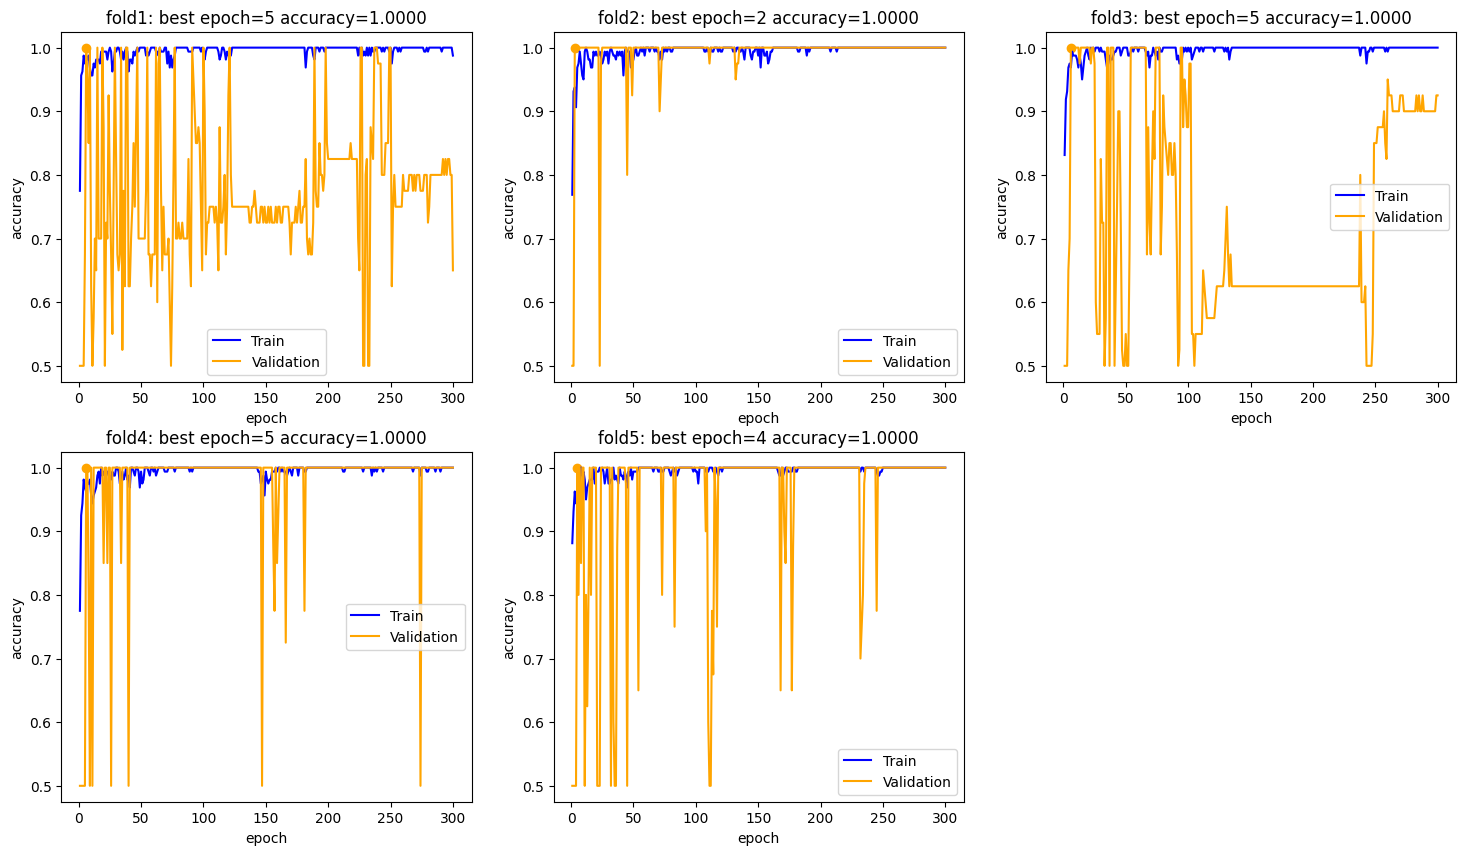

In [24]:
import os
import glob
import json
import matplotlib.pylab as plt

res_cv_path = glob.glob('results/result_cls_fold*')
res_log = []
for cv in res_cv_path:
    with open(os.path.join(cv, 'log'), 'r') as f:
        res_log.append(json.load(f))

%matplotlib inline

plt.figure(figsize=(18, 10))
for k in range(len(res_log)):
    train, val, epoch = [], [], []
    for n in range(1, len(res_log[k])+1):
        train.append(res_log[k][str(n)]['main/accuracy'])
        val.append(res_log[k][str(n)]['val/main/accuracy'])
        epoch.append(res_log[k][str(n)]['epoch'])
    plt.subplot(2, 3, k+1)
    plt.plot(epoch, train, label='Train', color='blue')
    plt.plot(epoch, val, label='Validation', color='orange')
    plt.scatter(np.argmax(val)+1, np.max(val), marker='o', color='orange')
    # plt.xticks(epoch)
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('fold{}: best epoch={} accuracy={:.4f}'.format(k+1, np.argmax(val), np.max(val)))
    plt.legend()

In [25]:
import numpy as np
import torch

def test(root_path, test_path, model_path, out='results/result_cls_test', device=-1):
    test_dataset = PreprocessedDataset(root_path, test_path, train=False)

    model = torch.load(model_path)

    tp, tn, fp, fn = 0, 0, 0, 0
    for i in range(test_dataset.__len__()):
        with torch.no_grad():
            x, t = test_dataset.__getitem__(i)
            y = model(torch.tensor(np.expand_dims(x, axis=0)))
        if np.argmax(y.data) == t:
            if t == 1:
                tp += 1
            else:
                tn += 1
        else:
            if t == 1:
                fn += 1
            else:
                fp += 1

    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    fscore = 2 * precision * recall / (precision + recall)

    os.makedirs(out, exist_ok=True)
    with open(os.path.join(out, 'result.txt'), 'w') as f:
        f.write('accuracy: {}\n'.format(accuracy))
        f.write('precision: {}\n'.format(precision))
        f.write('recall: {}\n'.format(recall))
        f.write('f-score: {}\n'.format(fscore))
    print('accuracy: {}'.format(accuracy))
    print('precision: {}'.format(precision))
    print('recall: {}'.format(recall))
    print('f-score: {}'.format(fscore))

In [26]:
root_path = '/content/drive/MyDrive/Colab_Notebooks/tokkuma_datasets/dataset_cls'
test_path = '/content/drive/MyDrive/Colab_Notebooks/tokkuma_datasets/dataset_cls/split_list/test.txt'
model_path = 'results/result_cls_fold5/best_model.npz'  # 最も精度の高いfoldのモデルを選択

test(root_path, test_path, model_path, 'results/result_cls_test', device="cuda:0")

accuracy: 1.0
precision: 1.0
recall: 1.0
f-score: 1.0


# **Grad-CAM**

### LIVE

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1373: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


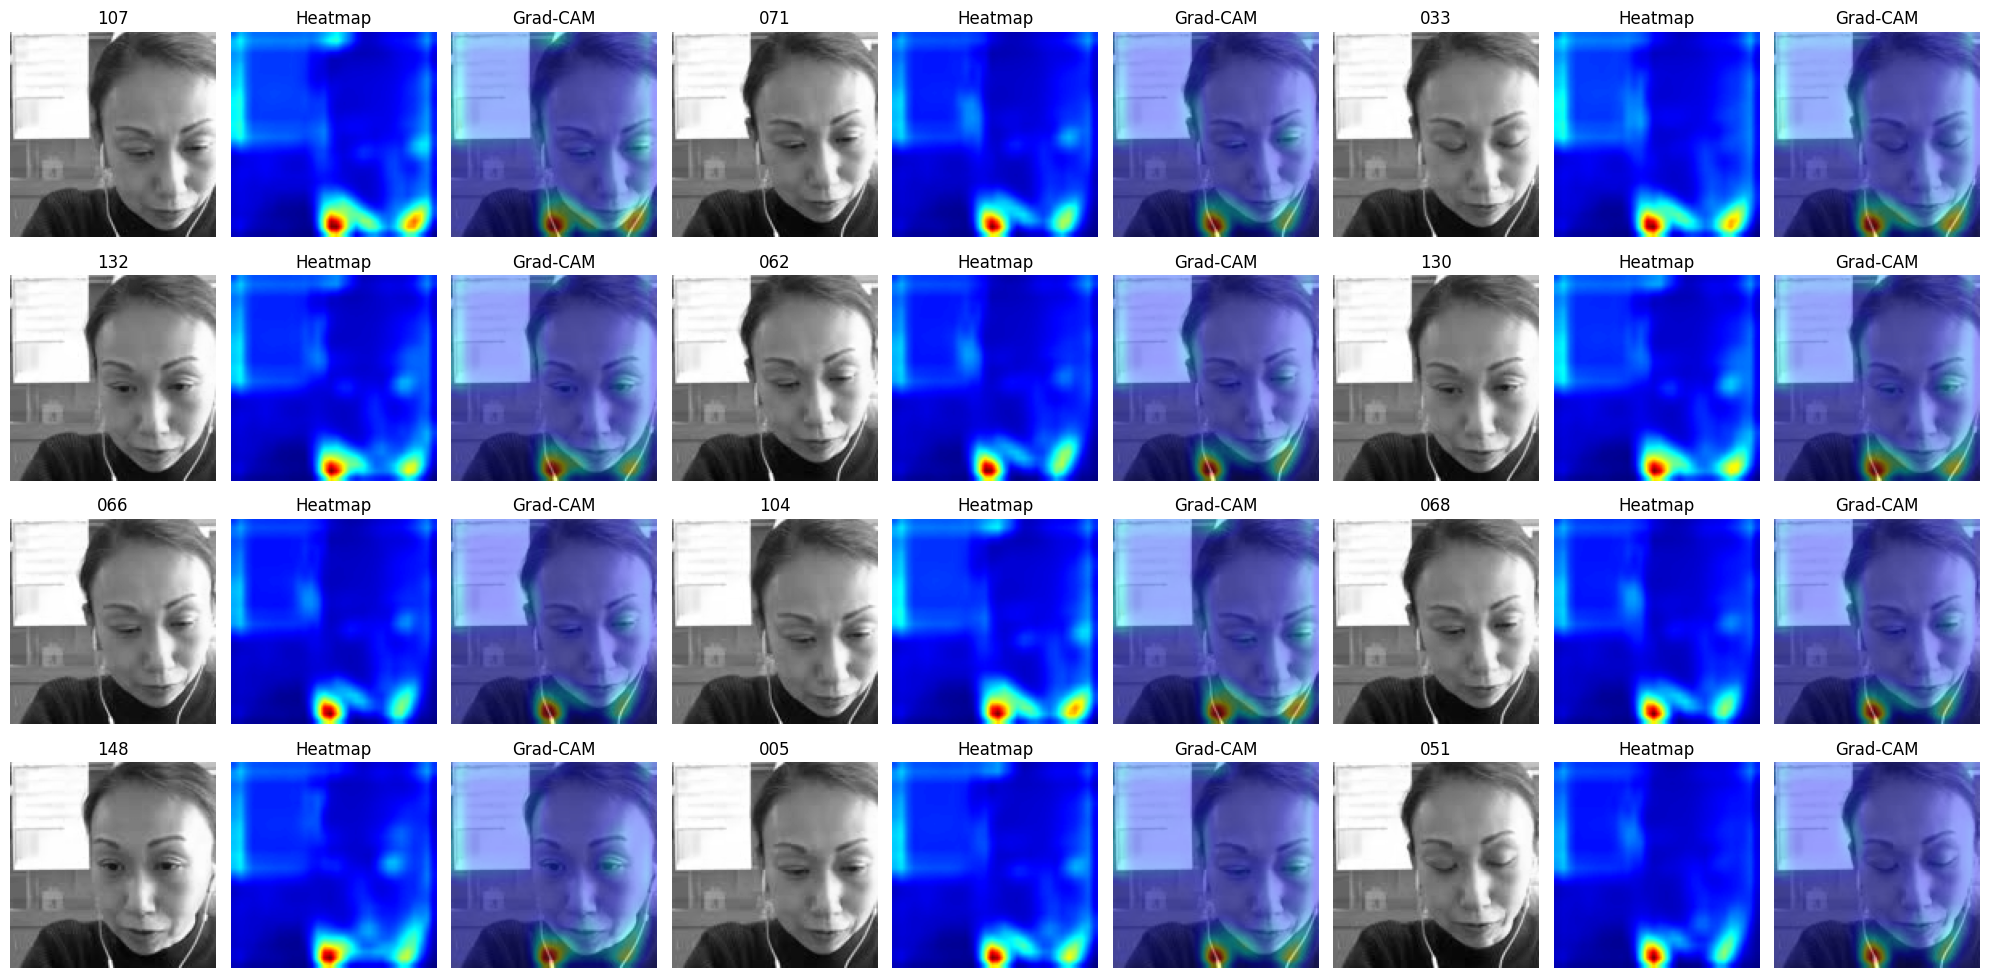

In [10]:

import os
import random
import cv2
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from skimage import io
import numpy as np

# GradCamクラスは変更なし
class GradCam:
  def __init__(self, model):
      self.model = model
      self.model.eval()
      self.feature = None
      self.gradient = None
      self.hooks = []

      def hook_function(module, input, output):
          self.feature = output
          self.gradient = None

      def gradient_hook(module, grad_input, grad_output):
          self.gradient = grad_output[0]

      self.hooks.append(model.conv3.register_forward_hook(hook_function))
      self.hooks.append(model.conv3.register_backward_hook(gradient_hook))

  def __call__(self, input_tensor, target_category=None):
      output = self.model(input_tensor)
      if target_category is None:
          target_category = torch.argmax(output).item()

      self.model.zero_grad()

      one_hot_output = torch.zeros((1, output.shape[-1]))
      one_hot_output[0][target_category] = 1
      output.backward(gradient=one_hot_output)

      gradients = self.gradient.cpu().data.numpy()[0]
      activations = self.feature.cpu().data.numpy()[0]
      weights = np.mean(gradients, axis=(1, 2))
      cam = np.zeros_like(activations[0])

      for i, w in enumerate(weights):
          cam += w * activations[i]

      cam = np.maximum(cam, 0)
      cam = cv2.resize(cam, (image.shape[1], image.shape[0]))
      cam = (cam - cam.min()) / (cam.max() - cam.min())
      cam = 1 - cam  # カラースケールを逆転させる

      return cam

# 画像をランダムに選択する関数
def select_random_images(folder_path, num_sets=12):
    all_images = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
    return random.sample(all_images, num_sets)

# モデルのロード
model_path = '/content/drive/MyDrive/Colab_Notebooks/tokkuma_datasets/dataset_cls/h_1.pth'
model = ClassificationModel()
model.load_state_dict(torch.load(model_path))

# Grad-CAMの初期化
grad_cam = GradCam(model)

# フォルダからランダムに画像を12セット選択
folder_path = "/content/drive/MyDrive/Colab_Notebooks/tokkuma_datasets/dataset_cls/live"
selected_images = select_random_images(folder_path, 12)

# グリッド表示のための準備
fig, axs = plt.subplots(4, 9, figsize=(20, 10))  # 4行9列のサブプロットを作成

# 選択された画像に対してGrad-CAMを適用
for idx, img_path in enumerate(selected_images):
    image = io.imread(img_path)
    image_tensor = torch.tensor(image, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
    cam = grad_cam(image_tensor)

    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    superimposed_img = heatmap * 0.4 + cv2.cvtColor(image, cv2.COLOR_GRAY2RGB) * 0.6

    # ファイル名（拡張子なし）を取得
    file_name = os.path.splitext(os.path.basename(img_path))[0]

    # グリッドに画像を配置
    row = idx // 3  # グリッドの行を計算
    col = (idx % 3) * 3  # グリッドの列を計算（3つの画像セットのために3倍する）

    axs[row, col].imshow(image, cmap='gray')
    axs[row, col].set_title(f'{file_name}')
    axs[row, col].axis('off')

    axs[row, col+1].imshow(heatmap)
    axs[row, col+1].set_title('Heatmap')
    axs[row, col+1].axis('off')

    axs[row, col+2].imshow(superimposed_img.astype(np.uint8))
    axs[row, col+2].set_title('Grad-CAM')
    axs[row, col+2].axis('off')

plt.tight_layout()
plt.show()

### DEAD

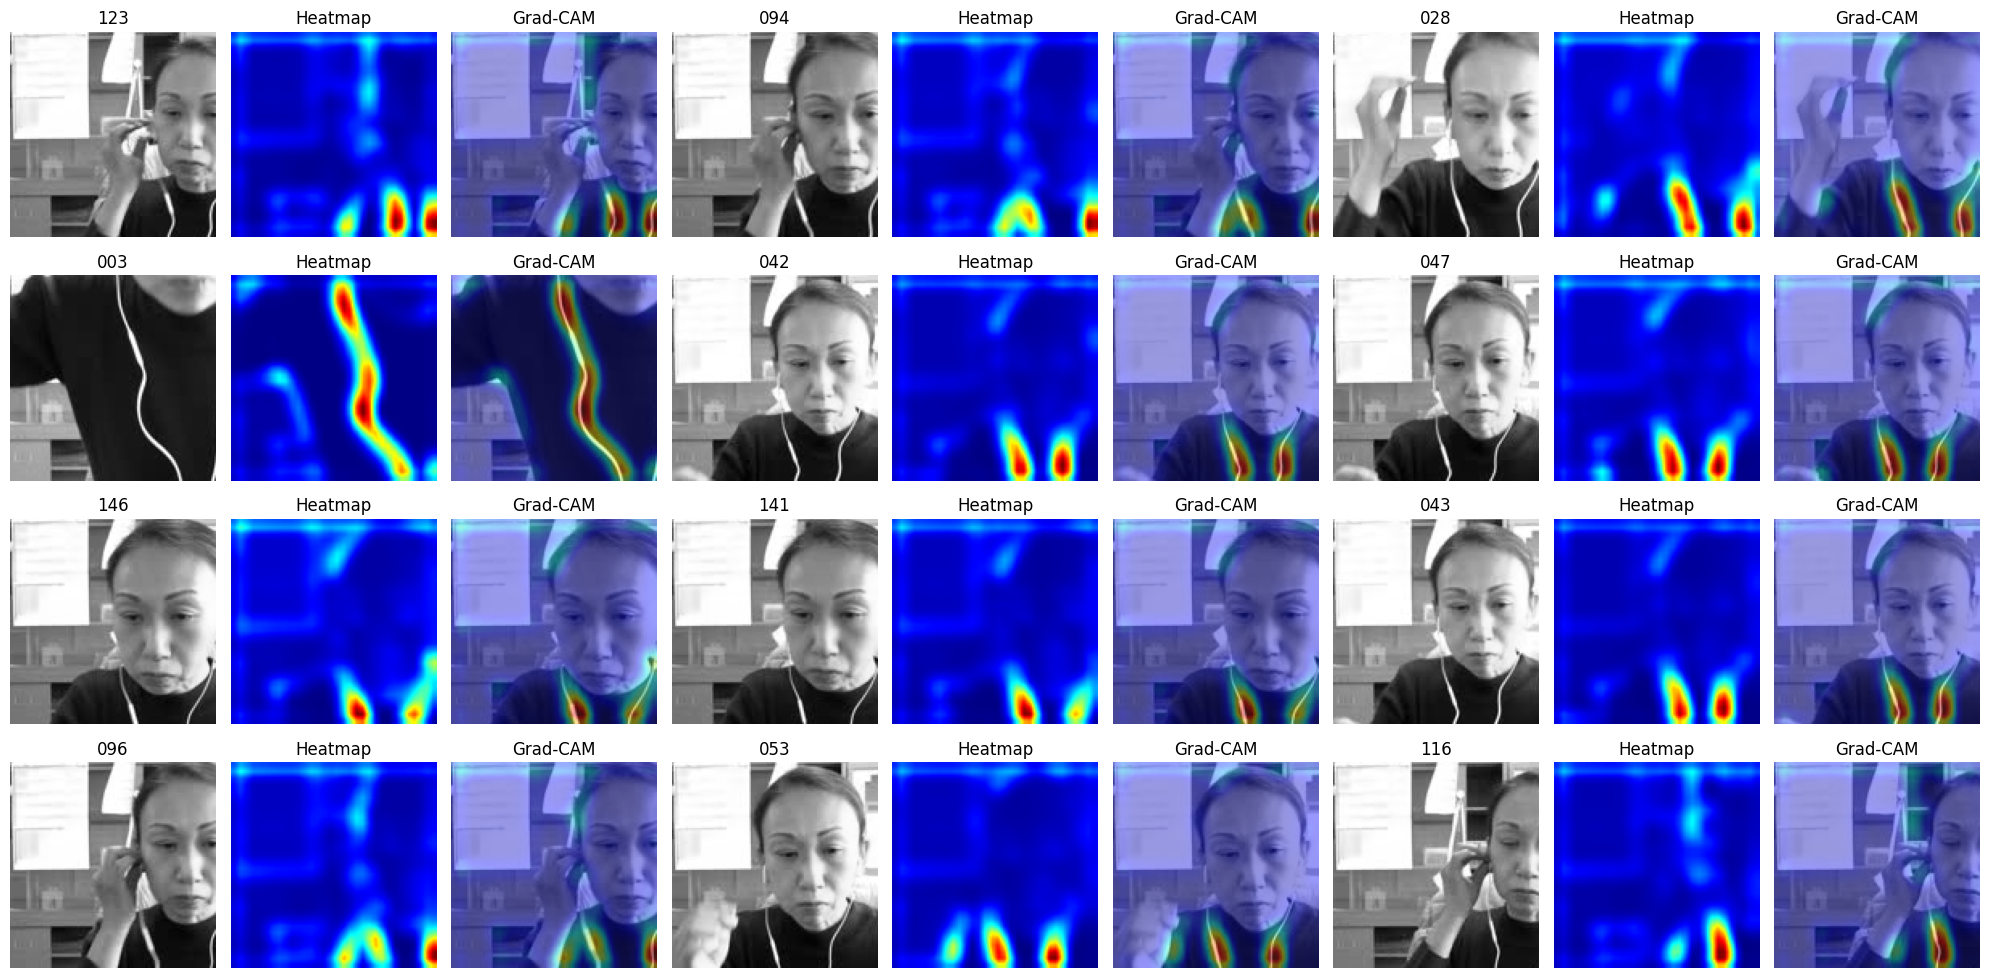

In [ ]:

import os
import random
import cv2
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from skimage import io
import numpy as np

# GradCamクラスは変更なし
class GradCam:
  def __init__(self, model):
      self.model = model
      self.model.eval()
      self.feature = None
      self.gradient = None
      self.hooks = []

      def hook_function(module, input, output):
          self.feature = output
          self.gradient = None

      def gradient_hook(module, grad_input, grad_output):
          self.gradient = grad_output[0]

      self.hooks.append(model.conv3.register_forward_hook(hook_function))
      self.hooks.append(model.conv3.register_backward_hook(gradient_hook))

  def __call__(self, input_tensor, target_category=None):
      output = self.model(input_tensor)
      if target_category is None:
          target_category = torch.argmax(output).item()

      self.model.zero_grad()

      one_hot_output = torch.zeros((1, output.shape[-1]))
      one_hot_output[0][target_category] = 1
      output.backward(gradient=one_hot_output)

      gradients = self.gradient.cpu().data.numpy()[0]
      activations = self.feature.cpu().data.numpy()[0]
      weights = np.mean(gradients, axis=(1, 2))
      cam = np.zeros_like(activations[0])

      for i, w in enumerate(weights):
          cam += w * activations[i]

      cam = np.maximum(cam, 0)
      cam = cv2.resize(cam, (image.shape[1], image.shape[0]))
      cam = (cam - cam.min()) / (cam.max() - cam.min())
      cam = 1 - cam  # カラースケールを逆転させる

      return cam

# 画像をランダムに選択する関数
def select_random_images(folder_path, num_sets=12):
    all_images = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
    return random.sample(all_images, num_sets)

# モデルのロード
model_path = '/content/drive/MyDrive/Colab_Notebooks/tokkuma_datasets/dataset_cls/hiroi_mw0515_1.pth'
model = ClassificationModel()
model.load_state_dict(torch.load(model_path))

# Grad-CAMの初期化
grad_cam = GradCam(model)

# フォルダからランダムに画像を12セット選択
folder_path = "/content/drive/MyDrive/Colab_Notebooks/tokkuma_datasets/dataset_cls/dead"
selected_images = select_random_images(folder_path, 12)

# グリッド表示のための準備
fig, axs = plt.subplots(4, 9, figsize=(20, 10))  # 4行9列のサブプロットを作成

# 選択された画像に対してGrad-CAMを適用
for idx, img_path in enumerate(selected_images):
    image = io.imread(img_path)
    image_tensor = torch.tensor(image, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
    cam = grad_cam(image_tensor)

    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    superimposed_img = heatmap * 0.4 + cv2.cvtColor(image, cv2.COLOR_GRAY2RGB) * 0.6

    # ファイル名（拡張子なし）を取得
    file_name = os.path.splitext(os.path.basename(img_path))[0]

    # グリッドに画像を配置
    row = idx // 3  # グリッドの行を計算
    col = (idx % 3) * 3  # グリッドの列を計算（3つの画像セットのために3倍する）

    axs[row, col].imshow(image, cmap='gray')
    axs[row, col].set_title(f'{file_name}')
    axs[row, col].axis('off')

    axs[row, col+1].imshow(heatmap)
    axs[row, col+1].set_title('Heatmap')
    axs[row, col+1].axis('off')

    axs[row, col+2].imshow(superimposed_img.astype(np.uint8))
    axs[row, col+2].set_title('Grad-CAM')
    axs[row, col+2].axis('off')

plt.tight_layout()
plt.show()

## EX

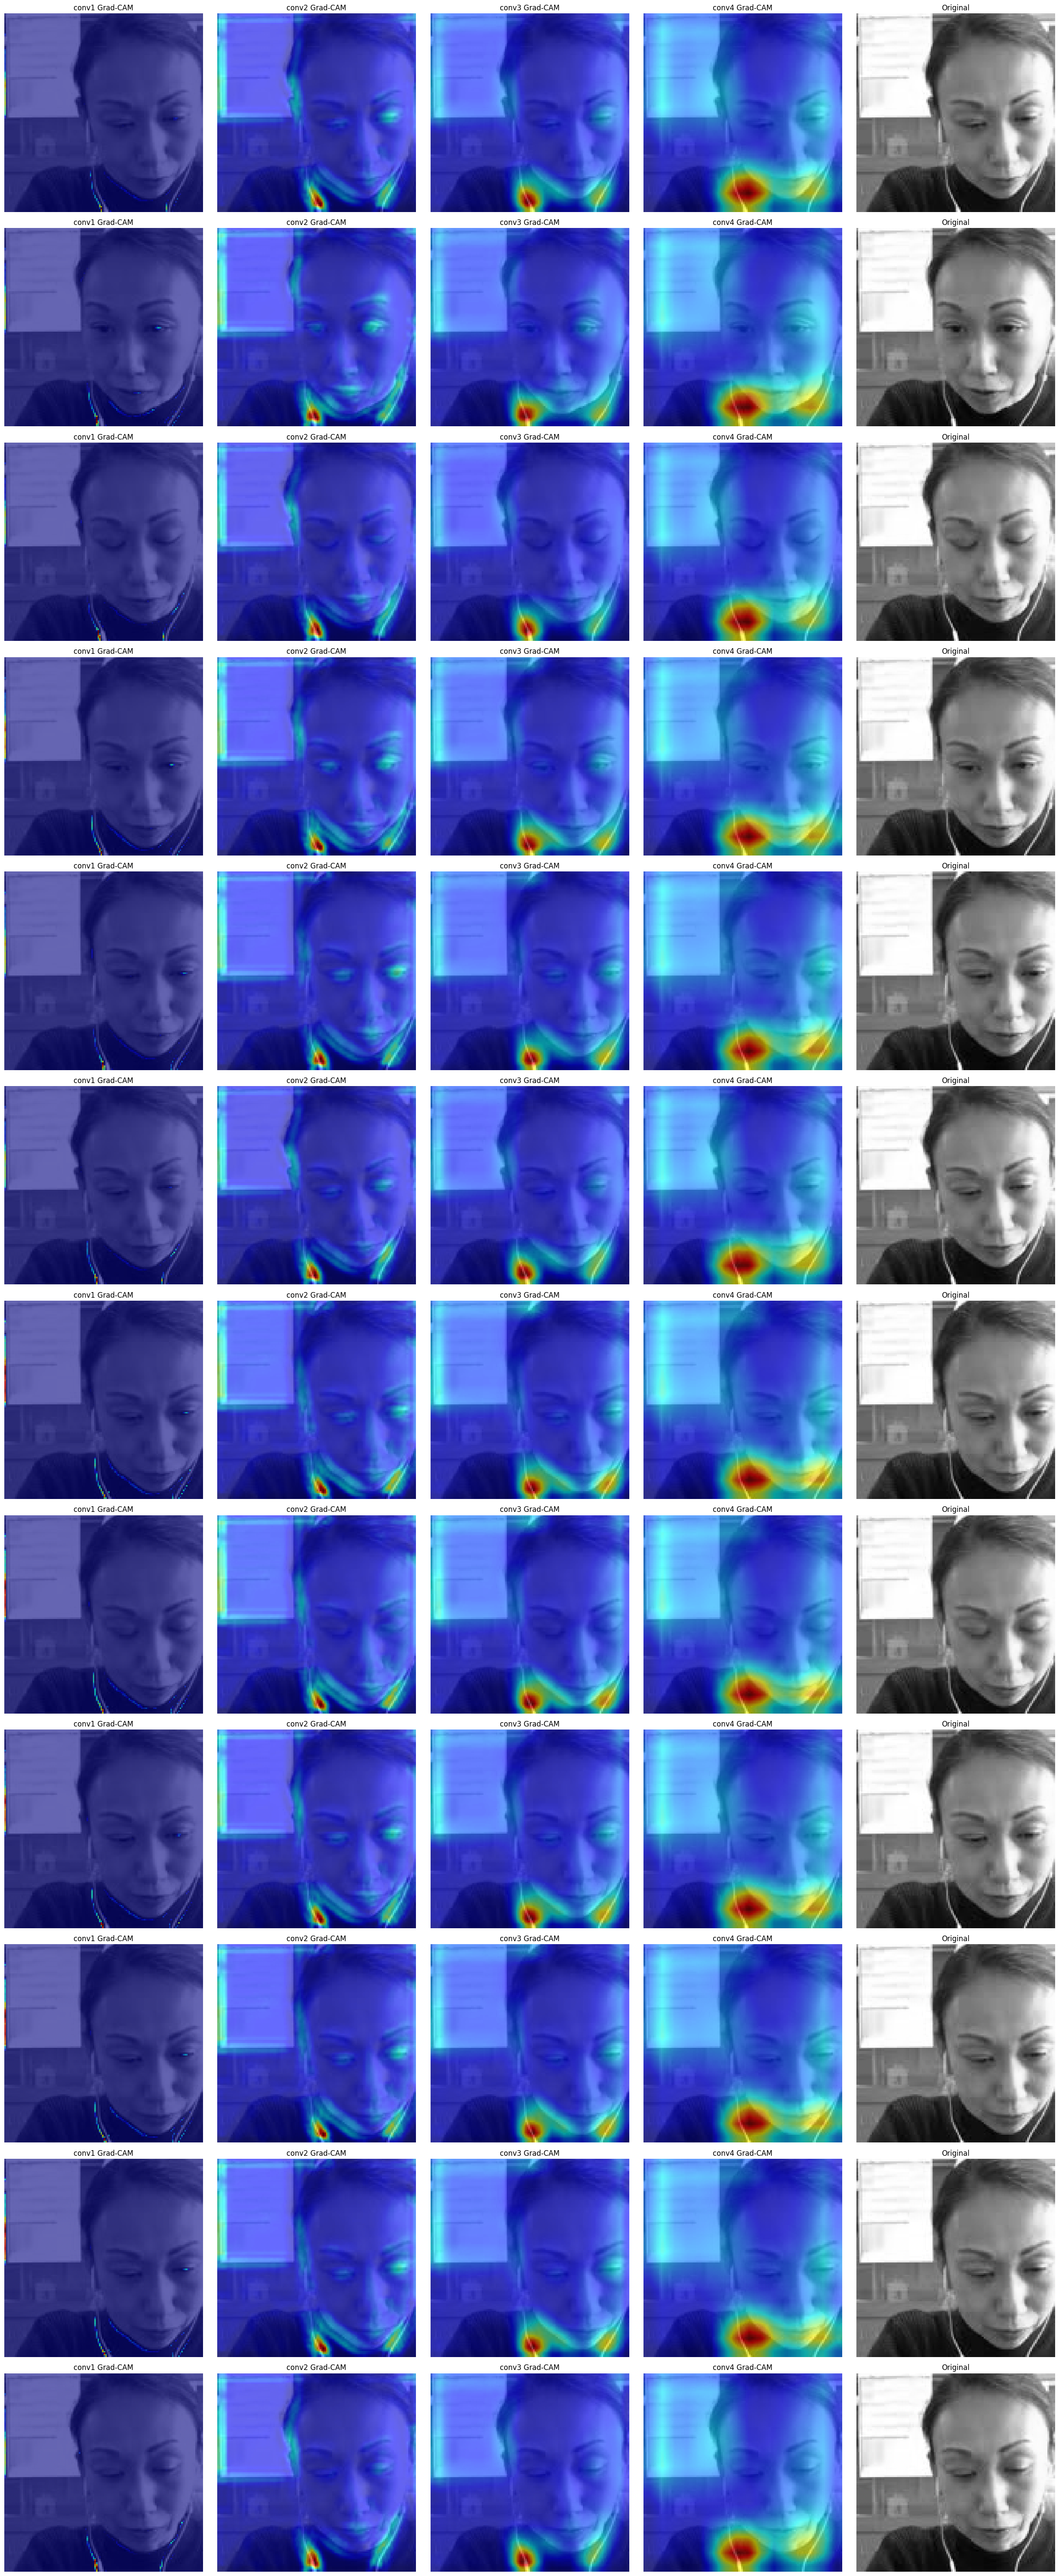

In [11]:
import os
import random
import cv2
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from skimage import io
import numpy as np

class GradCam:
    def __init__(self, model, layer_name):
        self.model = model
        self.model.eval()
        self.feature = None
        self.gradient = None
        self.hooks = []

        def hook_function(module, input, output):
            self.feature = output
            self.gradient = None

        def gradient_hook(module, grad_input, grad_output):
            self.gradient = grad_output[0]

        target_layer = getattr(model, layer_name)
        self.hooks.append(target_layer.register_forward_hook(hook_function))
        self.hooks.append(target_layer.register_backward_hook(gradient_hook))

    def __call__(self, input_tensor, target_category=None):
        output = self.model(input_tensor)
        if target_category is None:
            target_category = torch.argmax(output).item()

        self.model.zero_grad()

        one_hot_output = torch.zeros((1, output.shape[-1]))
        one_hot_output[0][target_category] = 1
        output.backward(gradient=one_hot_output)

        gradients = self.gradient.cpu().data.numpy()[0]
        activations = self.feature.cpu().data.numpy()[0]
        weights = np.mean(gradients, axis=(1, 2))
        cam = np.zeros_like(activations[0])

        for i, w in enumerate(weights):
            cam += w * activations[i]

        cam = np.maximum(cam, 0)
        cam = cv2.resize(cam, (image.shape[1], image.shape[0]))
        cam = (cam - cam.min()) / (cam.max() - cam.min())
        cam = 1 - cam

        return cam

model_path = '/content/drive/MyDrive/Colab_Notebooks/tokkuma_datasets/dataset_cls/h_1.pth'
model = ClassificationModel()
model.load_state_dict(torch.load(model_path))

layers = ['conv1', 'conv2', 'conv3', 'conv4']
grad_cams = {layer: GradCam(model, layer) for layer in layers}

folder_path = "/content/drive/MyDrive/Colab_Notebooks/tokkuma_datasets/dataset_cls/live"
selected_images = select_random_images(folder_path, 12)

fig, axs = plt.subplots(12, 5, figsize=(25, 60))  # 5列に修正

for idx, img_path in enumerate(selected_images):
    image = io.imread(img_path)
    image_tensor = torch.tensor(image, dtype=torch.float32).unsqueeze(0).unsqueeze(0)

    for i, layer in enumerate(layers):
        cam = grad_cams[layer](image_tensor)

        heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
        superimposed_img = heatmap * 0.6 + cv2.cvtColor(image, cv2.COLOR_GRAY2RGB) * 0.4

        axs[idx, i].imshow(superimposed_img.astype(np.uint8))
        axs[idx, i].set_title(f'{layer} Grad-CAM')
        axs[idx, i].axis('off')

    # オリジナルの画像を5列目に表示
    axs[idx, 4].imshow(image, cmap='gray')
    axs[idx, 4].set_title('Original')
    axs[idx, 4].axis('off')

plt.tight_layout()
plt.show()


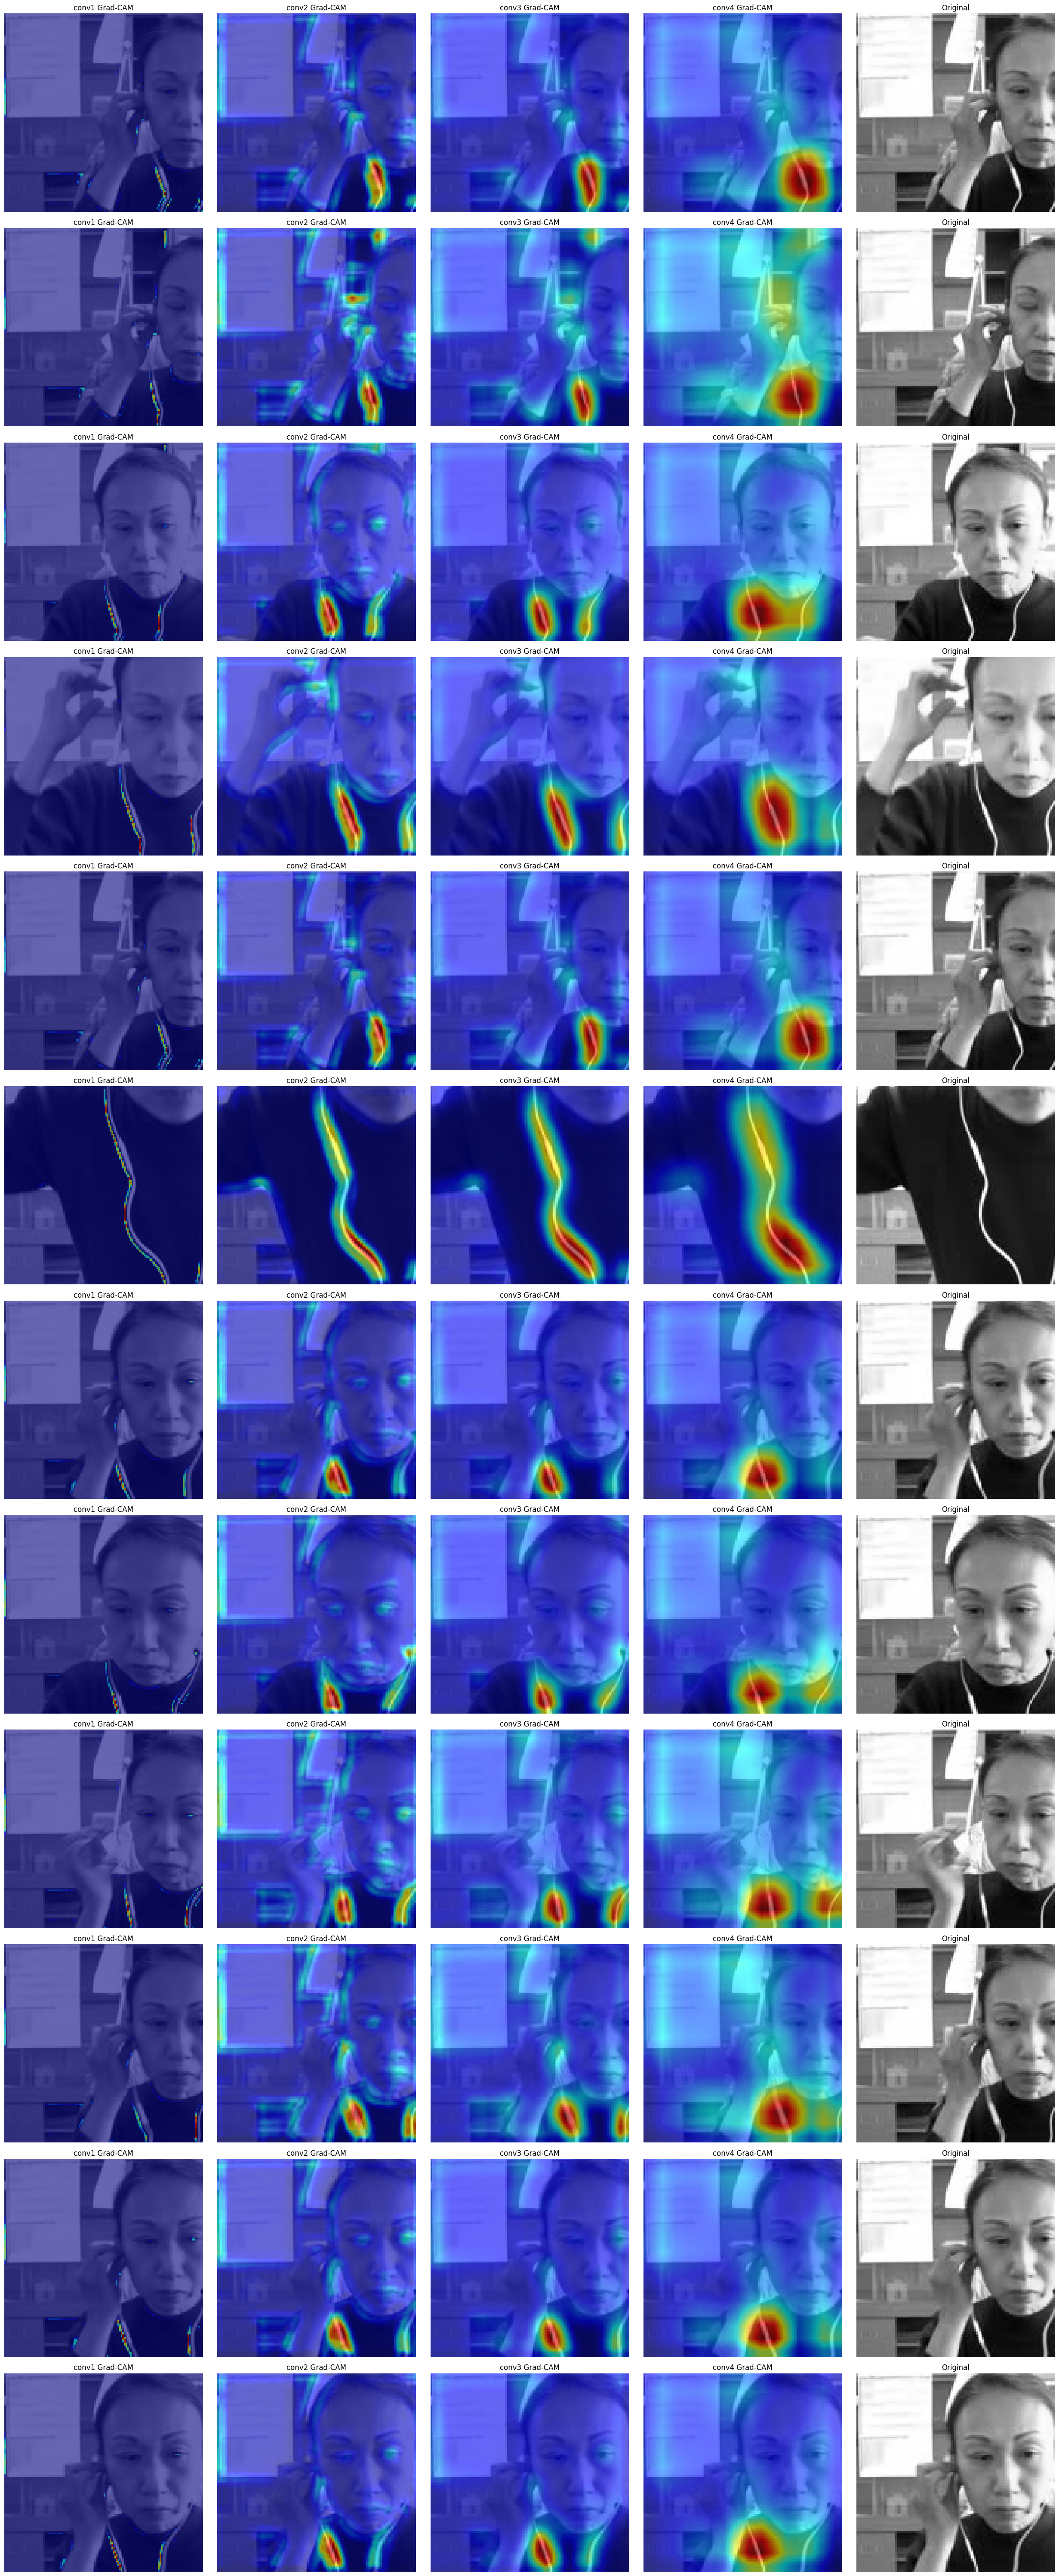

In [12]:
import os
import random
import cv2
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from skimage import io
import numpy as np

class GradCam:
    def __init__(self, model, layer_name):
        self.model = model
        self.model.eval()
        self.feature = None
        self.gradient = None
        self.hooks = []

        def hook_function(module, input, output):
            self.feature = output
            self.gradient = None

        def gradient_hook(module, grad_input, grad_output):
            self.gradient = grad_output[0]

        target_layer = getattr(model, layer_name)
        self.hooks.append(target_layer.register_forward_hook(hook_function))
        self.hooks.append(target_layer.register_backward_hook(gradient_hook))

    def __call__(self, input_tensor, target_category=None):
        output = self.model(input_tensor)
        if target_category is None:
            target_category = torch.argmax(output).item()

        self.model.zero_grad()

        one_hot_output = torch.zeros((1, output.shape[-1]))
        one_hot_output[0][target_category] = 1
        output.backward(gradient=one_hot_output)

        gradients = self.gradient.cpu().data.numpy()[0]
        activations = self.feature.cpu().data.numpy()[0]
        weights = np.mean(gradients, axis=(1, 2))
        cam = np.zeros_like(activations[0])

        for i, w in enumerate(weights):
            cam += w * activations[i]

        cam = np.maximum(cam, 0)
        cam = cv2.resize(cam, (image.shape[1], image.shape[0]))
        cam = (cam - cam.min()) / (cam.max() - cam.min())
        cam = 1 - cam

        return cam

model_path = '/content/drive/MyDrive/Colab_Notebooks/tokkuma_datasets/dataset_cls/h_1.pth'
model = ClassificationModel()
model.load_state_dict(torch.load(model_path))

layers = ['conv1', 'conv2', 'conv3', 'conv4']
grad_cams = {layer: GradCam(model, layer) for layer in layers}

folder_path = "/content/drive/MyDrive/Colab_Notebooks/tokkuma_datasets/dataset_cls/dead"
selected_images = select_random_images(folder_path, 12)

fig, axs = plt.subplots(12, 5, figsize=(25, 60))  # 5列に修正

for idx, img_path in enumerate(selected_images):
    image = io.imread(img_path)
    image_tensor = torch.tensor(image, dtype=torch.float32).unsqueeze(0).unsqueeze(0)

    for i, layer in enumerate(layers):
        cam = grad_cams[layer](image_tensor)

        heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
        superimposed_img = heatmap * 0.6 + cv2.cvtColor(image, cv2.COLOR_GRAY2RGB) * 0.4

        axs[idx, i].imshow(superimposed_img.astype(np.uint8))
        axs[idx, i].set_title(f'{layer} Grad-CAM')
        axs[idx, i].axis('off')

    # オリジナルの画像を5列目に表示
    axs[idx, 4].imshow(image, cmap='gray')
    axs[idx, 4].set_title('Original')
    axs[idx, 4].axis('off')

plt.tight_layout()
plt.show()
